In [1]:
from torchvision import models
import torchvision.transforms as T
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def decode_segmap(image, source, nc=21):
  
    label_colors = np.array([(0, 0, 0), 
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
   

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)

    foreground = cv2.imread(source)

    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))

    background = 255 * np.ones_like(rgb).astype(np.uint8)

    foreground = foreground.astype(float)
    background = background.astype(float)

    th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)

    alpha = cv2.GaussianBlur(alpha, (7,7),0)

    alpha = alpha.astype(float)/255

    foreground = cv2.multiply(alpha, foreground)  

    background = cv2.multiply(1.0 - alpha, background)  

    outImage = cv2.add(foreground, background)

    return outImage/255

def segment(net, path, show_orig=True, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    trf = T.Compose([ T.Resize(450), 
#                     T.CenterCrop(224), 
                    T.ToTensor(), 
                    T.Normalize(mean = [0.485, 0.456, 0.406], 
                                std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to()
    out = net.to()(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    
    rgb = decode_segmap(om, path)
    
    plt.imshow(rgb); plt.axis('off'); plt.show()

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


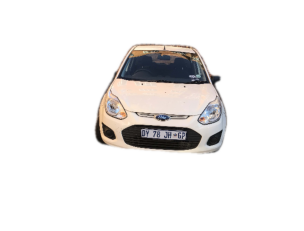

In [3]:
segment(dlab,r'C:\Users\Admin\Documents\Keshav\Programming\Open CV\Car Scan\view1.jpeg', show_orig=False)

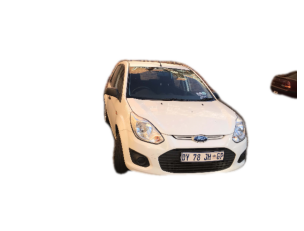

In [4]:
segment(dlab,r'C:\Users\Admin\Documents\Keshav\Programming\Open CV\Car Scan\view4.jpeg', show_orig=False)